Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [1]:
import itertools

from storageRingOptimizer import StorageRingModel
import numpy as np
from helperTools import *
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import time
from SwarmTracerClass import SwarmTracer
from latticeModels import make_Ring_And_Injector_Version3


X=[0.0250595 , 0.011     , 0.03889941, 0.01018058, 0.08487763,0.5       ]
PTL_Ring,PTL_Injector=make_Ring_And_Injector_Version3(X)
optimizer=StorageRingModel(PTL_Ring,PTL_Injector)


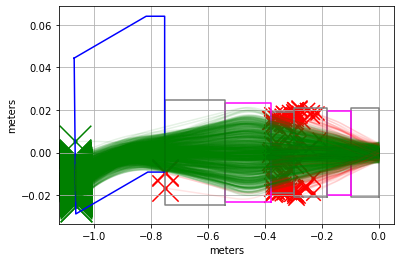

In [2]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6

swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=True,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4,logPhaseSpaceCoords=True)
optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=False,showTraceLines=True,traceLineAlpha=.1)
swarmRingInitial = optimizer.transform_Swarm_From_Injector_Frame_To_Ring_Frame(swarmInjectorTraced)


In [3]:
swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, 10.0,fastMode=True,energyCorrection=True,parallel=True)

In [ ]:
%matplotlib inline
optimizer.latticeRing.show_Lattice(swarm=swarmTraced)

In [ ]:
### vacuum survival

In [3]:
#trace through lattice
%matplotlib inline
import multiprocess as mp
def percentFluxMult(T,energyCons=True,parallel=False):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=parallel,
                            fastMode=fastMode, accelerated=True, copySwarm=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=True,showTraceLines=True,traceLineAlpha=.5)
    # print(swarmTraced.lattice_Flux())
    # print(sum([p.probability*p.revolutions for p in swarmTraced]))
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return 1e2*survivalFrac*swarmFluxMult/maxFluxMult

# TArr=np.logspace(np.log10(.05),np.log10(10),10)
# results=tool_Parallel_Process(percentFluxMult,TArr,resultsAsArray=True,processes=1)
print(percentFluxMult(10,energyCons=True,parallel=True),percentFluxMult(10,energyCons=False,parallel=True)) #23.11714456552582 27.85058846209365

27.77204588301954 29.309433965213557


In [15]:
flux=results[:,0]
fluxMax=results[:,1]
vacuumLine=(TArr*flux[0]/TArr[0])
maxLIne=(TArr*fluxMax[0]/TArr[0])
plt.scatter(TArr,flux/fluxMax)
plt.show()
plt.scatter(TArr,flux,label='simulation results')
plt.plot(TArr,vacuumLine,label='vacuum limited injected',c='r')
plt.plot(TArr,maxLIne,label='vacuum limited, ideal loading',c='g')
plt.ylabel('Flux multiplication')
plt.xlabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()
flux[-1],fluxMax[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# look at energy conservation

In [12]:
TMaxE_Test=.05
energyCorrection=False
swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, TMaxE_Test,fastMode=True,energyCorrection=energyCorrection)

In [13]:
particleEnergyTestList=[]
iList=[]
for i,particle in enumerate(swarmTraced):
    if particle.clipped==False:
        particleFresh=Particle(qi=particle.qi,pi=particle.pi)
        particleEnergyTestList.append(particleFresh)
        iList.append(i)
    if len(particleEnergyTestList)>=8:
        break
swarmE_Test=Swarm()
swarmE_Test.particles=particleEnergyTestList
print(iList) #[4, 5, 7, 10, 11]

[0, 1, 2, 4, 5, 6, 7, 8]


1.8225688934326172


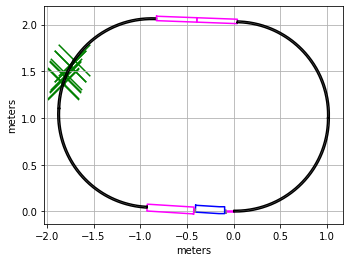

In [14]:
t=time.time()
swarmE_TestTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmE_Test, optimizer.h, TMaxE_Test, parallel=True, fastMode=False, stepsBetweenLogging=8,energyCorrection=energyCorrection)
print(time.time()-t)
PTL_Ring.show_Lattice(swarm=swarmE_TestTraced,showMarkers=True)

1.332213777786018


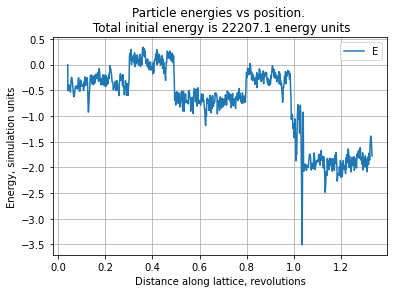

1.3568051739009648


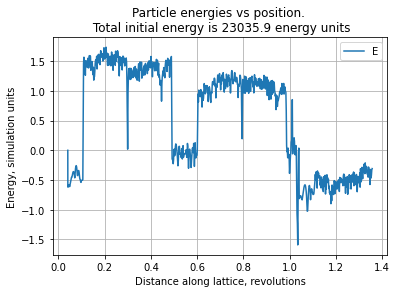

1.366330751619858


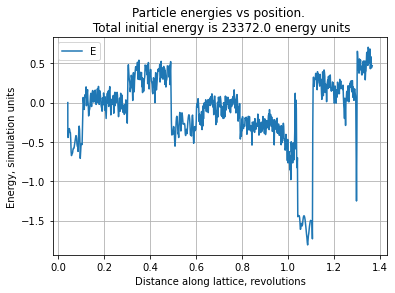

1.356591805163951


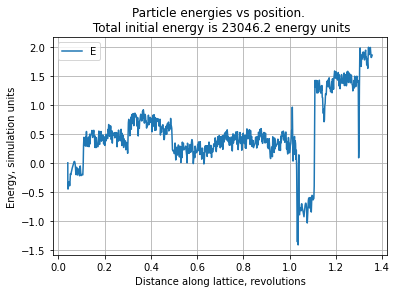

1.340856684310975


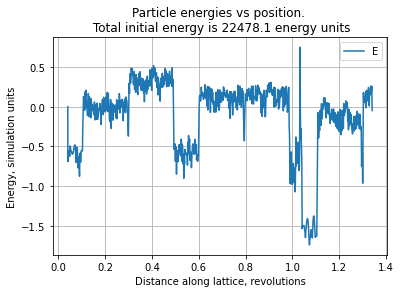

1.3455345537001673


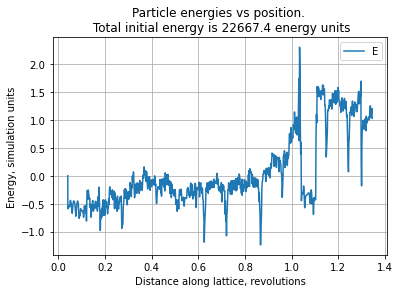

1.3308820592438406


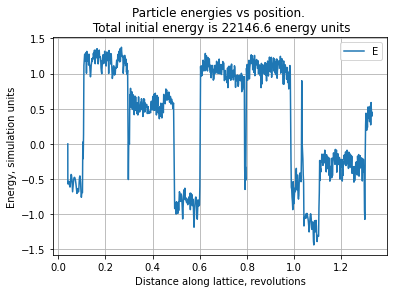

1.3421459250130625


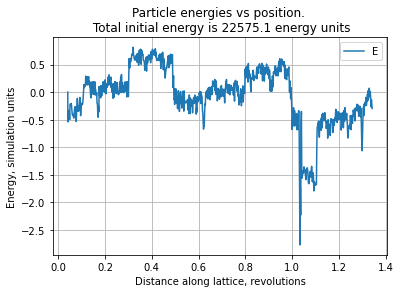

In [15]:
%matplotlib inline
for particle in swarmE_TestTraced:
    print(particle.revolutions)
    particle.plot_Energies(showOnlyTotalEnergy=True)
# swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
# p0Arr=swarmTraced.particles[0].p0Arr
# plt.plot(p0Arr)
# plt.show()